In [7]:
import pandas as pd
import pyarrow
import urllib.request as urllib2
import os
import json 
import pickle
import csv

import re
import numpy as np
from pathlib import Path
import tqdm
import networkx as nx


import seaborn as sns
import statistics as st
import string 
import typing as t
from tqdm import tqdm

import matplotlib.cm as cm 
import matplotlib.pyplot as plt

import fa2
try:
    import powerlaw
except ImportError:
    !pip install powerlaw
    import powerlaw


In [8]:
def calc_stats(graph_degrees: nx.Graph):
    """
    Calculate mean, median, mode, min and max of given graph degrees
    
    Returns
    -------
    Namespace
        Namespace with statistics
    """

    class Namespace:
        def __init__(self, **kwargs):
            self.__dict__.update(**kwargs)
        
        def __str__(self):
            return str(self.__dict__)

    degrees = [elem[1] for elem in sorted(graph_degrees, key=lambda x: x[1], reverse=True)]
    return Namespace(
        mean=st.mean(degrees),
        median=st.median(degrees),
        mode=st.mode(degrees),
        min=min(degrees),
        max=max(degrees),
    )

def print_header(title: str):
    """Prints pretty header"""
    print("="*20 + f" {title} " + "="*20 + "\n")

In [9]:
with open('data/data_all.pickle', 'rb') as f:
    data = pickle.load(f)

In [10]:
data['Human'] = np.nan
data.loc[data.Species == 'Human', 'Human'] = 'Human'
data.loc[data.Species != 'Human', 'Human'] = 'Other'

In [11]:
data

,Name,Paragraph,Neighbours,Species,Gender,Human
0,"""Backdraft""","""Backdraft"" was the nickname of a male human T...","[Canon, Human, Gender, Color, First_Order, Fir...",Human,Male,Human
1,"""Blue"" Imcrix","""Blue"" Imcrix was an infamous male Taloron cri...","[Star_Wars_Legends, Taloron, Legends, Legends,...",Taloron,Male,Other
2,"""Blue Five"" (Batuu)","""Blue Five"" was a female human pilot that flew...","[Canon, Batuu_system, First_Order-Resistance_W...",Human,Female,Human
3,"""Frog Lady""","""Frog Lady"" was the nickname of an amphibious ...","[Canon, Category:Articles_to_be_expanded, Talk...",Unidentified frog-like anthropoid,Female,Other
4,"""Frog Man""","""Frog Man"" was the husband of Frog Lady who li...","[Canon, Unidentified_frog-like_anthropoid, Gen...",Unidentified frog-like anthropoid,Male,Other
...,...,...,...,...,...,...
21202,ST-636,ST-636 was an Imperial stormtrooper who was pa...,"[Star_Wars_Legends, Legends, Legends, Legends,...",Human,Male,Human
21203,ST-789,ST-789 was an Imperial stormtrooper who was pa...,"[Star_Wars_Legends, Legends, Legends, Legends,...",Human,Male,Human
21204,ST-A1215,"ST-A1215 was a human Sith jet trooper, a varia...","[Canon, Exegol, 14_ABY, Human, Meter, Foot, Si...",Human,None,Human
21205,ST-I4191,ST-I4191 was a human Sith trooper who served i...,"[Canon, Exegol, 13_ABY, Human, Meter, Foot, Si...",Human,None,Human


In [12]:
# initialize universe directional graph
Universe = nx.DiGraph()
for _, character in data.iterrows():
    # add node with metadata for each character
    Universe.add_node(character.Name, human = character.Human, gender = character.Gender, species = character.Species)
    for connection in character.Neighbours:
        if connection in data.Name.values:
            # add edge between character and its connection if it's not a self loop
            if connection != character.Name:
                Universe.add_edge(character.Name, connection)

In [13]:
print(f"Number of nodes: {len(Universe.nodes)}")
print(f"Number of links: {len(Universe.edges)}")

Number of nodes: 21207
Number of links: 14528


In [14]:
# save graph as an edgelist
nx.write_edgelist(Universe, "data/universe.edgelist")

In [15]:
print_header("Universe stats")
in_stats = calc_stats(Universe.in_degree())
out_stats = calc_stats(Universe.out_degree())
print(f"In degree: {in_stats}")
print(f"Out degree: {out_stats}")

==================== Universe stats ====================

In degree: {'mean': 0.6850568208610365, 'median': 0, 'mode': 0, 'min': 0, 'max': 239}
Out degree: {'mean': 0.6850568208610365, 'median': 0, 'mode': 0, 'min': 0, 'max': 106}


In [16]:
in_degrees = [degree[1] for degree in Universe.in_degree() if degree[1] > 0]
in_degree_alpha = powerlaw.Fit(in_degrees).alpha
print(f"In degree slope: {in_degree_alpha:.2f}")

Calculating best minimal value for power law fit
In degree slope: 2.98


In [17]:
YELLOW = "#fce700"
BLUE = "#00d7fc"
GRAY = "#000000"

largest_component = sorted(nx.weakly_connected_components(Universe), key=len, reverse=True)[0]
Undirected_universe_lc = Universe.subgraph(largest_component).to_undirected()
# set node colors
node_color = ["#e6253e" if Undirected_universe_lc.nodes[node]["human"] == "Human" else "#000000" for node in Undirected_universe_lc.nodes]
# set node size
node_size = [Undirected_universe_lc.degree(node)//3 for node in Undirected_universe_lc.nodes]
# edge color
edge_color = []
for node1, node2 in Undirected_universe_lc.edges():
    universe1 = Undirected_universe_lc.nodes[node1]["human"]
    universe2 = Undirected_universe_lc.nodes[node2]["human"]
    if universe1 == universe2:
        if universe1 == "Human":
            edge_color.append(YELLOW)
        else:
            edge_color.append(BLUE)
    else:
        edge_color.append(GRAY)


In [18]:
# use Force Atlas 2
if not os.path.exists("data/"):
    os.makedirs("data")

FA_POSITIONS = "data/positions.pickle"
# load pickle with pre-calculated positions if present
if os.path.exists(FA_POSITIONS):
    with open(FA_POSITIONS, "rb") as rbfile:
        positions = pickle.load(rbfile)
else:
    positions = fa2.ForceAtlas2().forceatlas2_networkx_layout(Undirected_universe_lc, pos=None, iterations=2000)
    # save to pickle for later use
    with open(FA_POSITIONS, "wb") as wbfile:
        pickle.dump(positions, wbfile)

100%|██████████| 2000/2000 [06:49<00:00,  4.88it/s]

BarnesHut Approximation  took  87.35  seconds
Repulsion forces  took  310.78  seconds
Gravitational forces  took  0.89  seconds
Attraction forces  took  0.49  seconds
AdjustSpeedAndApplyForces step  took  4.92  seconds


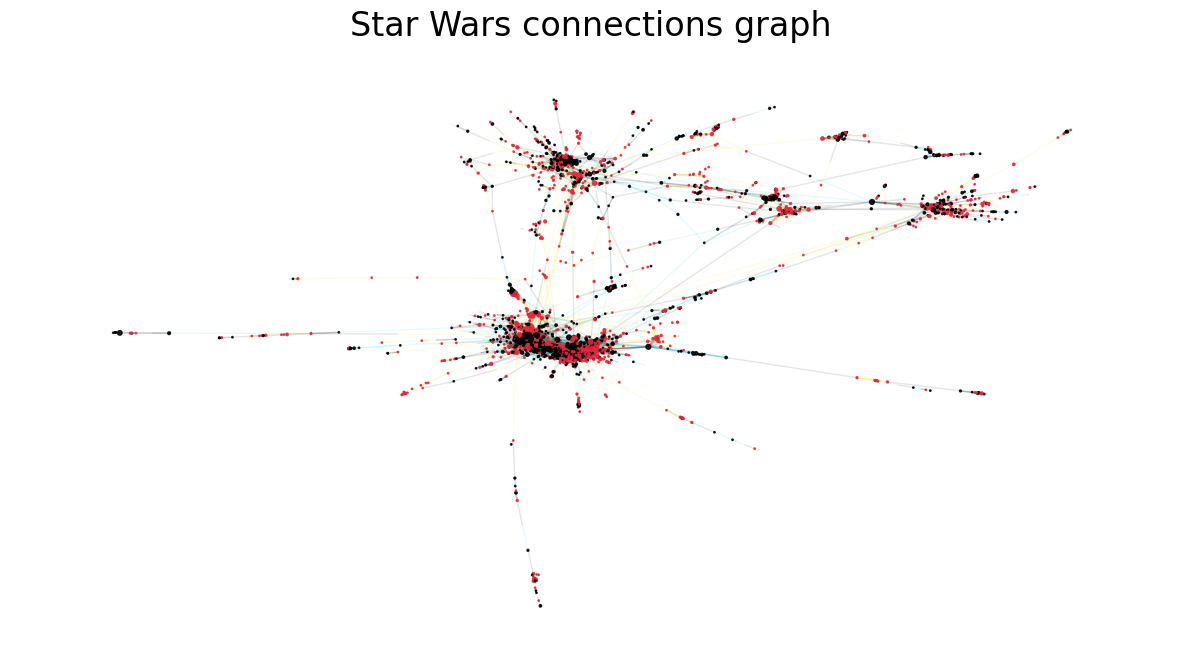

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
nx.draw_networkx_nodes(Undirected_universe_lc, positions, node_color=node_color, node_size=node_size, alpha=0.85, ax=ax)
nx.draw_networkx_edges(Undirected_universe_lc, positions, edge_color=edge_color, alpha=0.1, ax=ax)
ax.set_title("Star Wars connections graph", size=24)
ax.axis("off")
plt.show()